# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [ ]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. I represent a position as a 2-tuple of the form `(row, col)`. 

In [2]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


Visualize the maze

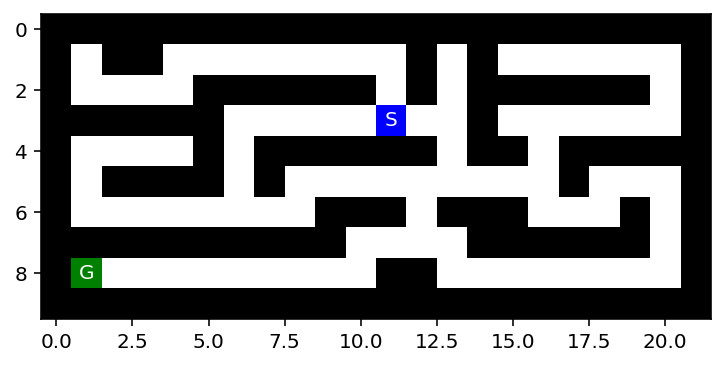

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [5]:
from numpy import random

class Node:
    move_NESW = {'N': (-1, 0), 'E': (0, 1), 'S':  (1, 0), 'W': (0, -1)}
    move_ESWN = {'E':  (0, 1), 'S': (1, 0), 'W': (0, -1), 'N': (-1, 0)}
    move_WSEN = {'W': (0, -1), 'S': (1, 0), 'E':  (0, 1), 'N': (-1, 0)}
    move_SENW = {'N': (-1, 0), 'E': (0, 1), 'S':  (1, 0), 'W': (0, -1)}
    dirs = ["nesw", "eswn", "wsen", "senw"]
    
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)
    
    def direction(location, speed = 1.0, rand=False):
        if rand == False:
            dx, dy =  Node.move_NESW[location]
            return (dx * speed, dy * speed)
        
        if rand == True:
            move_order = random.choice(Node.dirs)
            
            if move_order == 'nesw': dx, dy = Node.move_NESW[location]
            if move_order == 'eswn': dx, dy = Node.move_ESWN[location]
            if move_order == 'wsen': dx, dy = Node.move_WSEN[location]
            if move_order == 'senw': dx, dy = Node.move_SENW[location]
            return (dx * speed, dy * speed)

If needed, then you can add more fields to the class.


__Tree and memory management example:__ Create the root node and append the node for going east with a cost of 1.

In [6]:
import sys

print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))
# Note: -1 is used because passing root to getrefcount adds one reference
print("Root is now referenced twice. Reference count for garbage collection (root node):", sys.getrefcount(root)-1)

print()
print("Note that the root node is safe from garbage collection as long as we have also a reference in node2") 
root = None
print(root)
print("parent of node2 (reference to root node): ", repr(node2.parent))
print("Reference count for garbage collection (root node):", sys.getrefcount(node2.parent)-1)

print()
print("Path from root to node2")
path = node2.get_path_from_root()
print("References:", path)
print("Positions:", [n.pos for n in path])
print("Actions:", [n.action for n in path])
print("Cost:", [n.cost for n in path])


print()
print("Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage collection.")
node2 = None

Create root node
root: Node - pos = (0, 0); action = None; cost = 0
root (reference): <__main__.Node object at 0x7f5938a2fb80>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); action = E; cost = 1
parent of node2:  Node - pos = (0, 0); action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x7f5938a2fb80>
Root is now referenced twice. Reference count for garbage collection (root node): 2

Note that the root node is safe from garbage collection as long as we have also a reference in node2
None
parent of node2 (reference to root node):  <__main__.Node object at 0x7f5938a2fb80>
Reference count for garbage collection (root node): 1

Path from root to node2
References: [<__main__.Node object at 0x7f5938a2fb80>, <__main__.Node object at 0x7f5938c35070>]
Positions: [(0, 0), (0, 1)]
Actions: [None, 'E']
Cost: [0, 1]

Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage colle

# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth
* Maximum size of the frontier

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

In [7]:
# Your answer goes here

- **Initial State**: Defined as 'S' starting location (or (row, column))
- **Actions**: { North, East, West, South }
- **Transition Model**: $n(4^{n})$
- **Goal State**: Defined as 'G' destination location (or (row, column))
- **Path Cost**: The sum of non-negative step costs

## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information during search in the tree, and the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint, you need to implement DFS in a different way without a `reached` data structure and by releasing nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. You will see in your experiments that open spaces are a problem.

#### Breadth-First Search (BFS)

In [8]:
f = open("open_maze.txt", "r")
maze_str = f.read()

%run maze_helper.py
maze = parse_maze(maze_str)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [9]:
from numpy import random
import queue

class myQueue:
    def __init__(self): self.list = []
    def push(self,item): self.list.insert(0,item)
    def pop(self): return self.list.pop()
    def isEmpty(self): return len(self.list) == 0

def BreadthFirstSearch(problem, debug=False, visualize=False):
    root = Node(pos=find_pos(problem, what="S"), parent=None, action=None, cost=0)
    
    if find_pos(problem, what="G") == root.pos: return root.pos
    frontier = []
    reached = {}
    reached[root.pos] = [(root.pos, " ")]
    
    path = myQueue()
    path.push(root.pos)
    
    while not path.isEmpty():
    while len(frontier) != 0:
        node = frontier.pop()
        node = node.pos
        #if find_pos(problem, what="G") == node: break
        
        # For each child in Expand(problem, node) do:  
        for child in Expand(problem, node):
            s = child[0]
            print(child[0])
            if find_pos(problem, what="G") == s:
                while len(frontier) != 0:
                    node = frontier.pop()
                break
                
            if child[0] not in reached:
                reached[s] = [(node, child[1])]
                #problem[s] = 'F'
                #node2 = Node(pos=child[0], parent=node, action=child[1], cost=node.cost+1)
                #cost = int(child[2]) + 1
                #print("1:", child[0], "| 2:", child[1], "| 3:", child[2])
                #node2 = Node(pos=s, parent=child, action=child[1], cost=child[2])
                frontier.insert(0,Node(pos=s, parent=child, action=child[1], cost=child[2]))
                #frontier.insert(0, Node(pos=s, parent=child, action=child[1], cost=child[2]))
                #node2 = Node(pos=s, parent=child.parent, action=child.action, cost=child.cost)
                #frontier.insert(0, node2)
                
                #if visualize: show_maze(problem)
                #problem[s] = '.'
                #if debug: print("Adding to frontier:", s)
                
                #x = reached[node.pos]
                #if x[0][0] != root: problem[x[0][0]] = '.'
                
        if debug: print("Frontier:", frontier)
        if visualize:
            print("Path length:")
            print("Reached squares:", len(reached))
            show_maze(problem)
            #if child not in reached:
            #    frontier.insert(0, child[0])
            #    reached[child[0]] = [(node, child[1])]
            #    #if child[0] != find_pos(problem, what="G"):
            #        #problem[child[0]] = '.'
            #        if debug == True: print('Adding to frontier:', child[0])
                        
    x = reached[node.pos]
    while (x[0][0] is not root.pos):
        problem[x[0][0]] = 'P'
        if debug == True: print()
        frontier.insert(0, x[0][1])
        x = reached[x[0][0]]
        #path_counter += 1
    
    frontier.insert(0, x[0][1])
    print("Path length:", len(frontier))
    print("Reached squares:", len(reached))
        
    return frontier

def Expand(problem, node):
    s = []
    
    r = random.choice(Node.dirs) 
    if r == 'nesw': dir_ = Node.move_NESW
    if r == 'eswn': dir_ = Node.move_ESWN
    if r == 'wsen': dir_ = Node.move_WSEN
    if r == 'senw': dir_ = Node.move_SENW
    
    for action in dir_:
        x, y = node
        dx, dy = dir_[action]
        dx2, dy2 = int(x + dx), int(y + dy)
        if look(problem, ([dx2],[dy2])) != 'X':
            s2 = (dx2, dy2)
            cost = lambda s2: 1
            s.append((s2, action, 1))
    return s

(2, 35)
(1, 34)
(2, 34)
(3, 35)
(1, 35)
(1, 33)
(2, 34)
(1, 35)
(1, 34)
(2, 35)
(3, 34)
(2, 33)
(4, 35)
(3, 34)
(2, 35)
(1, 34)
(2, 33)
(1, 32)
(2, 34)
(3, 35)
(4, 34)
(3, 33)
(1, 33)
(2, 34)
(3, 33)
(2, 32)
(4, 34)
(5, 35)
(3, 35)
(1, 33)
(2, 32)
(1, 31)
(4, 33)
(5, 34)
(4, 35)
(3, 34)
(3, 34)
(4, 33)
(3, 32)
(2, 33)
(2, 33)
(3, 32)
(2, 31)
(1, 32)
(6, 35)
(5, 34)
(4, 35)
(1, 32)
(2, 31)
(1, 30)
(3, 33)
(4, 34)
(5, 33)
(4, 32)
(4, 34)
(5, 35)
(6, 34)
(5, 33)
(3, 31)
(4, 32)
(3, 33)
(2, 32)
(2, 32)
(3, 31)
(2, 30)
(1, 31)
(5, 35)
(7, 35)
(6, 34)
(1, 31)
(2, 30)
(1, 29)
(5, 32)
(6, 33)
(5, 34)
(4, 33)
(3, 32)
(4, 33)
(5, 32)
(4, 31)
(6, 33)
(7, 34)
(6, 35)
(5, 34)
(2, 31)
(3, 32)
(4, 31)
(3, 30)
(1, 30)
(2, 31)
(3, 30)
(2, 29)
(6, 35)
(8, 35)
(7, 34)
(1, 30)
(2, 29)
(1, 28)
(5, 31)
(6, 32)
(5, 33)
(4, 32)
(6, 34)
(7, 33)
(6, 32)
(5, 33)
(3, 31)
(4, 32)
(5, 31)
(4, 30)
(6, 34)
(7, 35)
(8, 34)
(7, 33)
(2, 30)
(3, 31)
(4, 30)
(3, 29)
(1, 29)
(2, 30)
(3, 29)
(2, 28)
(9, 35)
(8, 34)
(7, 35)


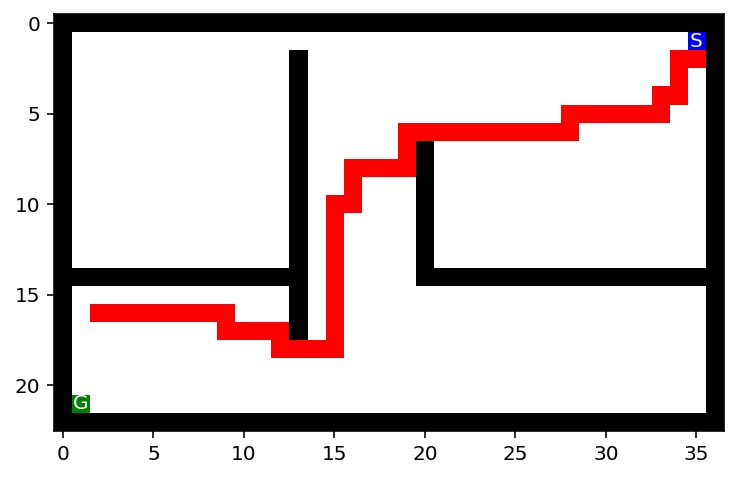

In [10]:
%time result = BreadthFirstSearch(maze, debug=False, visualize=False)
show_maze(maze)
#result


---------------------

#### Depth-First Search (DFS)

In [11]:
def DepthFirstSearch(problem, l):
    frontier <-- a LIFO queue (stack) with NODE(problem.INITIAL) as an element
    result  <-- failure
    
    while not frontier.isEmpty():
        node = frontier.pop()
        if find_pos(problem, what="G") == node.pos: return node
        if DEPTH(node) > l then
            result <-- cutoff
        else if not IS-CYCLE(node) do
            for each child in EXPAND(problem, node) do
                frontier.add(child)
    return result

    
    

SyntaxError: invalid syntax (<ipython-input-11-ef0a3f54d70c>, line 2)

How does BFS and DFS deal with loops (cycles)?

In [ ]:
# Discussion

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [ ]:
# Discussion

## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [ ]:
# Your code goes here

#### Greedy Best-First Search (GBFS)

In [ ]:
def GreedyBestFirstSearch():
    


----------------------------

#### A * Search

In [ ]:
def AStarSearch():
    

Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Discussion

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts. 

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [ ]:
# Add code, table, charts.

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | nodes expanded | max tree depth | max tree size | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [ ]:
# Add discussion

## Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

In [ ]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [ ]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [ ]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [ ]:
# Your code/answer goes here